In [23]:
import networkx as nx
import pandas as pd
from cdlib import algorithms
import seaborn as sns
import numpy as np

In [2]:
g = nx.read_graphml('data/airportsAndCoord.graphml')

In [3]:
print("nb nodes:", len(g.nodes))
print("nb edges:", len(g.edges()))

nb nodes: 3373
nb edges: 13547


In [4]:
print("density:", nx.density(g))
print("global clustering coeffeiient:", nx.transitivity(g))

density: 0.002382150628165401
global clustering coeffeiient: 0.24767449354443705


In [5]:
# We cannot compute the average path length because the graph is not connected
largest_CC = max(nx.connected_components(g), key=len)
g_CC = g.subgraph(largest_CC)


In [ ]:
print("average path length:", nx.average_shortest_path_length(g_CC))
# it takes <3 minutes... networkx is mostly written in python, so it is slow
print("diameter:", nx.diameter(g_CC))

In [15]:
#get dataframe of nodes with degree
df = pd.DataFrame.from_dict(dict(g.degree()), orient='index',columns=['degree'])

In [17]:
df.sort_values(by=['degree'], ascending=False).head(20)

degree
PAR_Paris                   248
LON_London_(GB)             240
FRA_Frankfurt               234
AMS_Amsterdam               191
CHI_Chicago                 183
MOW_Moscow                  179
NYC_New_York                178
ATL_Atlanta                 171
DFW_Dallas/Fort_Worth       147
HOU_Houston                 144
ZRH_Zurich                  143
MUC_Munich                  142
BRU_Brussels                135
ROM_Rome                    134
LAX_Los_Angeles_(US)        132
MIL_Milan                   129
DEN_Denver                  119
MSP_Minneapolis/St_Paul     115
YTO_Toronto                 115
VIE_Vienna                  115

In [20]:
random_graph = nx.gnm_random_graph(len(g.nodes), len(g.edges()))
r_cc = max(nx.connected_components(random_graph), key=len)
gr_cc = random_graph.subgraph(r_cc)
print("random graph density:", nx.density(gr_cc))
print("random graph transitivity:", nx.transitivity(gr_cc))
print("random graph average path length:", nx.average_shortest_path_length(gr_cc))

random graph density: 0.0023835639480278546
random graph transitivity: 0.0022669259194411937
random graph average path length: 4.1356002791234845


## Small Worldness
* As mentioned in class, we observe that the transitivity (global Clustering coefficient) of a random graph is approximately equal to its density
* The average path lenght is approximately similar in the random graph and in the observed graph
* The average path lenght is "small", it is in the order of magnitude of log(n)
* The clustering coefficient is much larger in the real graph (*100), 2 orders of magnitude of difference

So we can conclude that **the network is small world**


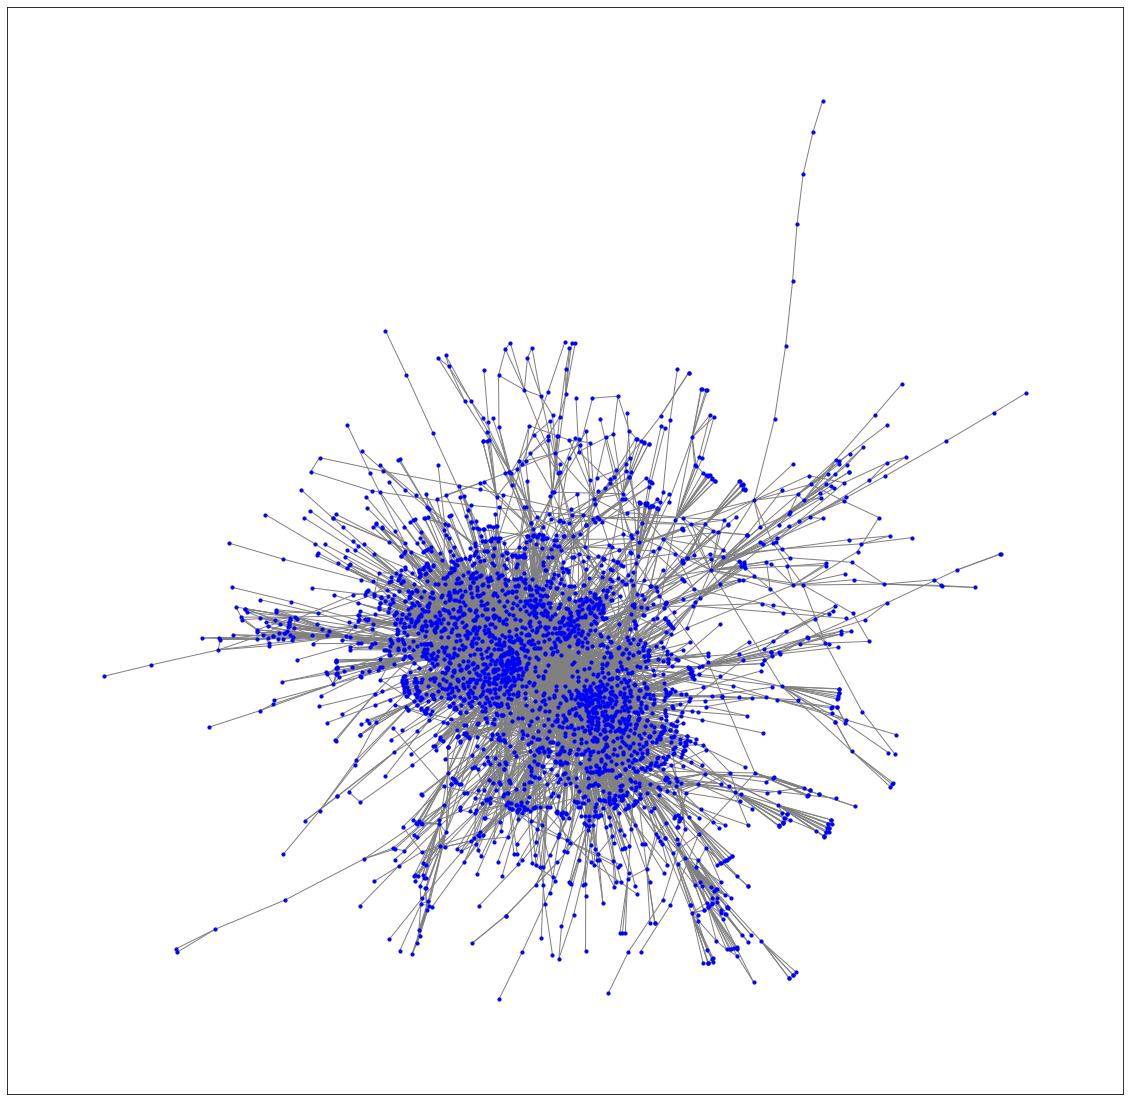

In [22]:
# networkx is not very convenient to plot large graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
nx.draw_networkx(g_CC, with_labels=False, node_size=10, node_color='blue', edge_color='grey')
plt.show()

In [40]:
communities = algorithms.louvain(g_CC, weight='')

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_as_map(g,c):
    x= list(nx.get_node_attributes(g,"lon").values()) 
    y= list(nx.get_node_attributes(g,"lat").values())
    coms_dict=c.to_node_community_map() 
    hues=list(coms_dict[n][0] for n in g.nodes())
    plt.figure(figsize=(12,8)) 
    plot = sns.scatterplot(x=x,y=y,hue=hues,palette=sns.color_palette ("tab20",len(c.communities)),s=5)
    plot.legend_.remove()

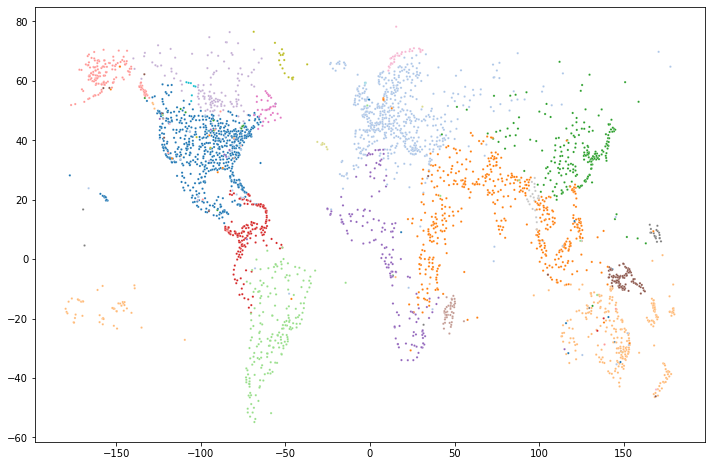

In [48]:
plot_as_map(g_CC,communities)

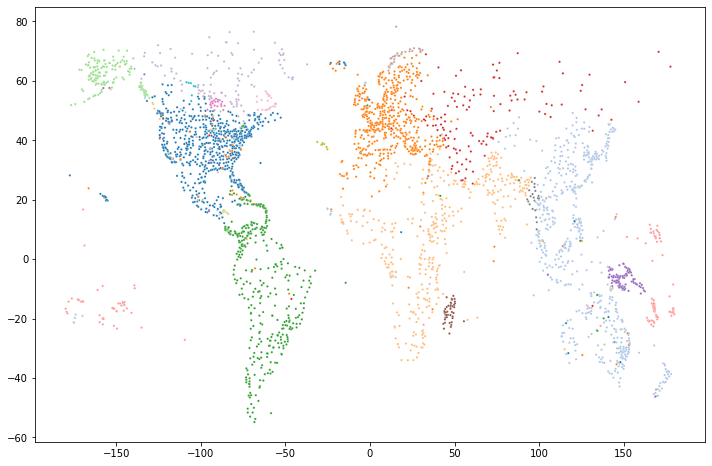

In [66]:
plot_as_map(g_CC,algorithms.louvain(g_CC, resolution=0.85,weight="fdsf"))

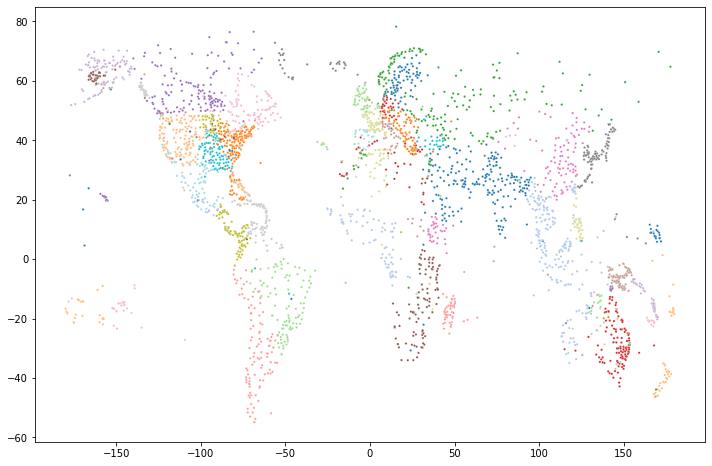

In [63]:
plot_as_map(g_CC,algorithms.louvain(g_CC, resolution=4,weight="dsfsd"))

## Analysis
* When we increase the resolution, it tends to find smaller communities. Communities become closer to countries, or states for large countries
* When we decrease the resolution, it tends to find larger communities. Close to continent, for instance. However, in this network, it quickly breaks and yields counterintuitive partitions


In [6]:
countries = nx.get_node_attributes(g_CC,"country")


In [11]:
countries
#as list of list
com_countries = {}
for n,country in countries.items():
    com_countries.setdefault(country, []).append(n)
list_of_list_countries = list(com_countries.values())
list_of_list_countries

[['AAA_Anaa',
  'HOI_Hao_Island',
  'PPT_Papeete',
  'GMR_Gambier_Island',
  'MKP_Makemo',
  'AUQ_Atuona',
  'BOB_Bora_Bora',
  'HUH_Huahine',
  'KKR_Kaukura_Atoll',
  'MOZ_Moorea',
  'NHV_Nuku_Hiva',
  'MVT_Mataiva',
  'RFP_Raiatea_Island',
  'RGI_Rangiroa_Island',
  'RUR_Rurutu',
  'TIH_Tikehau_Atoll',
  'TKX_Takaroa',
  'TUB_Tubuai',
  'XMH_Manihi',
  'MAU_Maupiti_Island',
  'TKP_Takapoto'],
 ['AKL_Auckland',
  'BHE_Blenheim',
  'CHC_Christchurch',
  'GIS_Gisborne',
  'HLZ_Hamilton_(NZ)',
  'KAT_Kaitaia',
  'KKE_Kerikeri',
  'NPE_Napier-Hastings',
  'NPL_New_Plymouth',
  'NSN_Nelson',
  'PMR_Palmerston_North',
  'ROT_Rotorua',
  'TRG_Tauranga',
  'TUO_Taupo',
  'WAG_Wanganui',
  'WHK_Whakatane',
  'WLG_Wellington',
  'WRE_Whangarei',
  'ZQN_Queenstown',
  'DUD_Dunedin',
  'HKK_Hokitika',
  'IVC_Invercargill',
  'MON_Mount_Cook',
  'TEU_Te_Anau',
  'TIU_Timaru',
  'WSZ_Westport',
  'HAA_Hasvik',
  'GOE_Gonalia'],
 ['HNL_Honolulu',
  'LAX_Los_Angeles_(US)',
  'ATL_Atlanta',
  'CHI_Chi

In [12]:
from cdlib import NodeClustering


nc = NodeClustering(list_of_list_countries,g_CC, "GroundTruth")

In [15]:
# compute the ami between the ground truth and the louvain communities
from cdlib.evaluation import adjusted_mutual_information
communities = algorithms.louvain(g_CC)
adjusted_mutual_information(nc,communities)


MatchingResult(score=0.5761163922834933, std=None)

In [28]:
resolutions = list(np.arange(0.1,1,0.1))
resolutions+=list(np.arange(1,20,1))
amis=[]
for resolution in resolutions:
    communities = algorithms.louvain(g_CC, resolution=resolution)
    print("resolution:",resolution, "adjusted_mutual_information:", adjusted_mutual_information(nc,communities).score)
    amis.append(adjusted_mutual_information(nc,communities).score)

resolution: 0.1 adjusted_mutual_information: 0.4191645497226788
resolution: 0.2 adjusted_mutual_information: 0.415998892786022
resolution: 0.30000000000000004 adjusted_mutual_information: 0.35721264118378265
resolution: 0.4 adjusted_mutual_information: 0.4424578996970016
resolution: 0.5 adjusted_mutual_information: 0.5151887217957201
resolution: 0.6 adjusted_mutual_information: 0.5204930375969444
resolution: 0.7000000000000001 adjusted_mutual_information: 0.536778148534428
resolution: 0.8 adjusted_mutual_information: 0.5520454914015805
resolution: 0.9 adjusted_mutual_information: 0.5792535666633167
resolution: 1 adjusted_mutual_information: 0.6094451232554986
resolution: 2 adjusted_mutual_information: 0.6648487261647272
resolution: 3 adjusted_mutual_information: 0.6982298220103518
resolution: 4 adjusted_mutual_information: 0.7156271402823876
resolution: 5 adjusted_mutual_information: 0.7202323691554897
resolution: 6 adjusted_mutual_information: 0.7290348971005042
resolution: 7 adjusted

<Axes: >

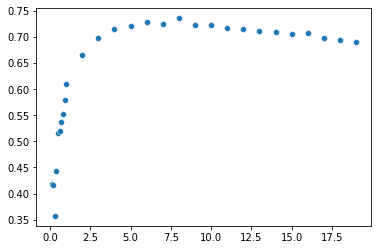

In [29]:
sns.scatterplot(x=resolutions,y=amis)

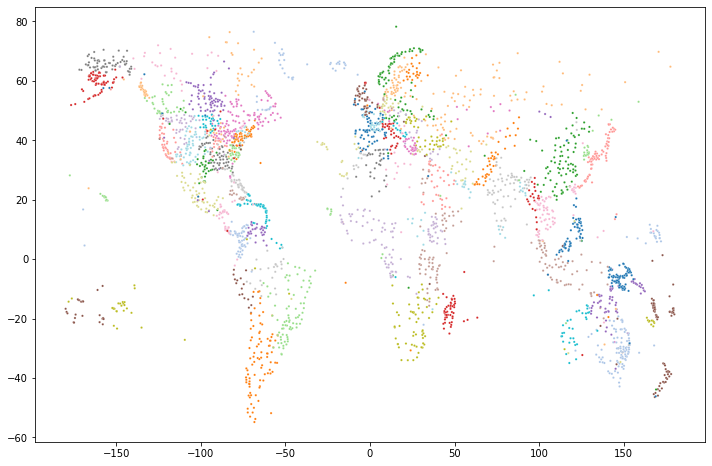

In [34]:
plot_as_map(g_CC,algorithms.louvain(g_CC, resolution=8))